OBSERVATIONS

g:  3x120s\
r:  3x120s\
i:  3x120s\
Ha: 1x900s + 4x300s\
Hb: 4x1200s

# H alpha

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.patches import Circle

import glob
from astropy.io import fits
from matplotlib.colors import LogNorm

from photutils.background import (Background2D, MedianBackground)  # For estimating the background
from photutils.background import BkgZoomInterpolator               # For interpolating the background
from astropy import stats as astrostats

import gc

In [2]:
file_path = ['data/data_Ha_filter_30_10_24/IC5146_Ha_000.fit']

In [3]:
# Open the FITS file

Ha_filter_RAW = []

for f_p in file_path:
    
    with fits.open(f_p) as hdul:
        #hdul.info()                        # Display information about the FITS file contents
        
        Ha_filter_RAW.append(hdul[0].data)   # Access the primary data (assuming image is in the primary HDU)

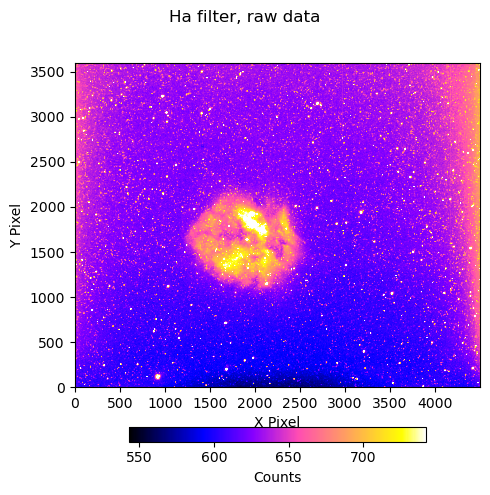

In [4]:
# Display RAW IMAGES 

fig, ax = plt.subplots(figsize=(5, 5))  # ax is a single AxesSubplot when only one subplot is created
fig.suptitle("Ha filter, raw data")

# Single subplot, so no need to iterate
im = ax.imshow(Ha_filter_RAW[0], clim=np.quantile(Ha_filter_RAW[0], [0.01, 0.99]), cmap='gnuplot2', origin='lower')  
plt.colorbar(im, ax=ax, location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Attach colorbar to the single subplot
ax.set(xlabel="X Pixel", ylabel="Y Pixel")  # Set labels for the single axis

plt.tight_layout()
plt.show()



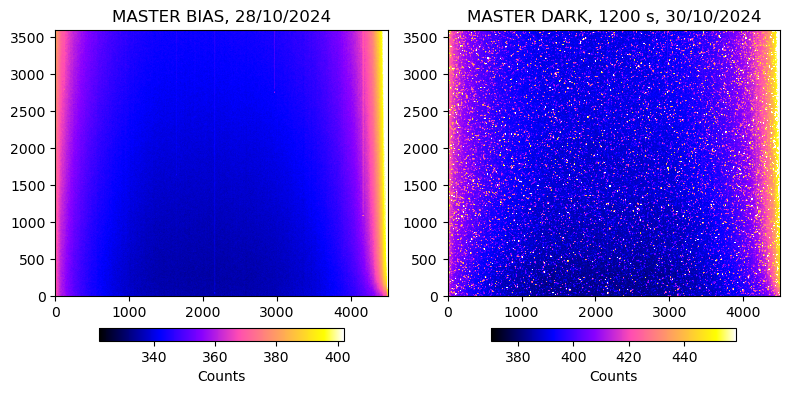

In [5]:
### MASTER BIAS and DARK

with fits.open('master_bias.fit') as hdul:
    #hdul.info()                # Display information about the FITS file contents
    master_bias = hdul[0].data  # Access the primary data (assuming image is in the primary HDU)

with fits.open('master_dark.fit') as hdul:
    #hdul.info()                # Display information about the FITS file contents
    master_dark = hdul[0].data  # Access the primary data (assuming image is in the primary HDU)

# Display master bias and master dark

fig, ax = plt.subplots(1,2,figsize=(8,4))

im1 = ax[0].imshow(master_bias, clim=np.quantile(master_bias, [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
plt.colorbar(im1, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Make sure to use the `im` object for colorbar
ax[0].set_title("MASTER BIAS, 28/10/2024")
#ax[i].set(xlabel="X Pixel",ylabel="Y Pixel")

im2 = ax[1].imshow(master_dark, clim=np.quantile(master_dark, [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
plt.colorbar(im2, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Make sure to use the `im` object for colorbar
ax[1].set_title("MASTER DARK, 1200 s, 30/10/2024")
#ax[i].set(xlabel="X Pixel",ylabel="Y Pixel")

#plt.subplots_adjust(bottom=0.15) 
plt.tight_layout()
plt.show()

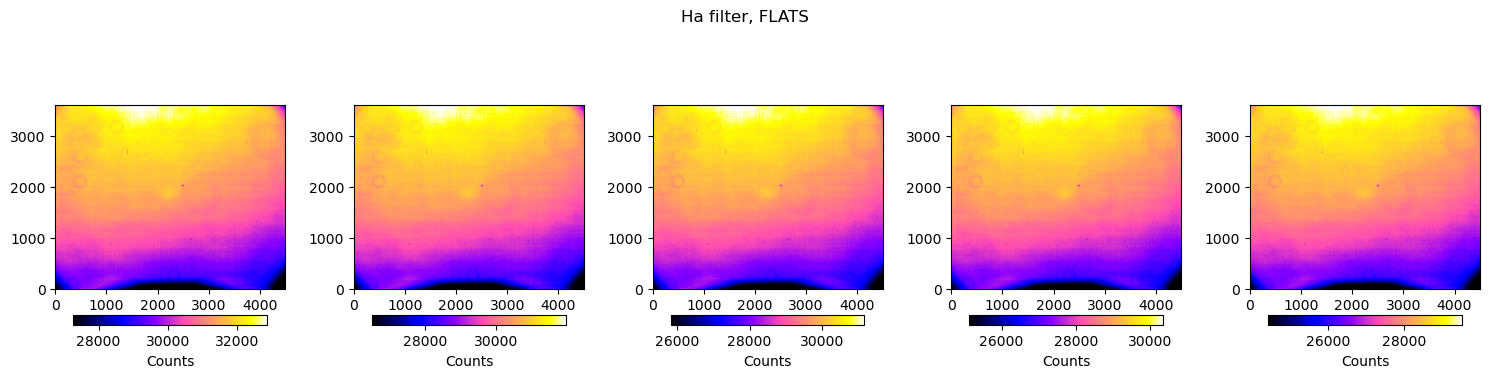

In [6]:
# Path to the FITS files
file_path = [f'data/flat_Ha_30_10_24/Calib_01{str(i).zfill(1)}flat_m20_Ha_4s.fit' for i in range(0,5)]

# Open the FLAT files
flat = []

for f_p in file_path:    
    with fits.open(f_p) as hdul:
        #hdul.info()    # Display information about the FITS file contents
        flat.append(hdul[0].data)  # Access the primary data (assuming image is in the primary HDU)

fig, ax = plt.subplots(1,5,figsize=(15,4))
fig.suptitle("Ha filter, FLATS")

for i in range(5):

            #plt.colorbar(fraction=0.0375, pad=0.02);
    
    im = ax[i].imshow(flat[i], clim=np.quantile(flat[i], [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
    plt.colorbar(im, ax=ax[i], location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Make sure to use the `im` object for colorbar
    #ax[i].set(xlabel="X Pixel",ylabel="Y Pixel")

#plt.subplots_adjust(bottom=0.15) 
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [7]:
### normalize each flat to it's mean value

for i in range(len(flat)):
    flat[i] = flat[i]/np.mean(flat[i]) 

# stack and take the mean as the master flat (???)

flat_stack = np.stack(flat, axis=0)  
flat_mean = np.mean(flat_stack, axis=0)   

del flat, flat_stack  # Replace with the names of your variables
gc.collect();



We read the detector after some time of no light going in, measuring the dark current counts (+ the bias, of course).\
We can repeat the measure for different exposure times, obtaining a curve of the dark current counts as a function of the exposure time.

$\text{Science}_\text{corrected} = \left[ \text{Science} - \left(\text{Dark} - \text{Bias}\right) \dfrac{\Delta t_\text{Science}}{\Delta t_\text{Dark}} - \text{Bias} \right] {\huge/} \text{Flat}$ 

In [8]:
Ha_filter_science = []

dt_science = 900
dt_dark = 1200

for i in range(1):
    science = (Ha_filter_RAW[i] - (master_dark-master_bias)*dt_science/dt_dark - master_bias)/flat_mean
    Ha_filter_science.append(science)

del Ha_filter_RAW, master_dark, master_bias, flat_mean  
gc.collect();

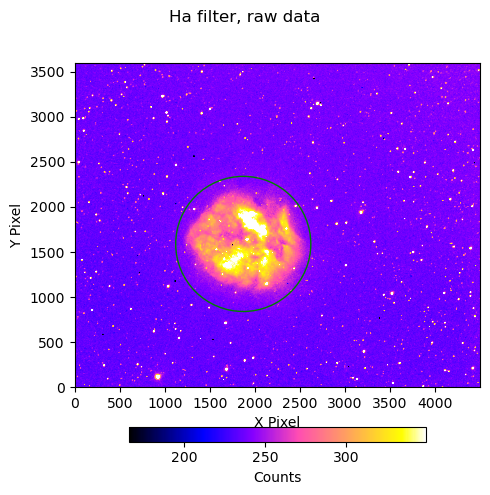

In [9]:
# Display science IMAGES 

fig, ax = plt.subplots(figsize=(5, 5))  # ax is a single AxesSubplot when only one subplot is created
fig.suptitle("Ha filter, science frame")

# Single subplot, so no need to iterate
im = ax.imshow(Ha_filter_science[0], clim=np.quantile(Ha_filter_science[0], [0.01, 0.99]), cmap='gnuplot2', origin='lower')  
plt.colorbar(im, ax=ax, location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Attach colorbar to the single subplot
ax.set(xlabel="X Pixel", ylabel="Y Pixel")  # Set labels for the single axis

radius = 750
center = (1870,1590)
ax.add_patch(Circle(center, radius, color='green', fill=False))


plt.tight_layout()
plt.show()





In [10]:
# Sky subtraction

Y, X = np.ogrid[:3599, :4499]
radius = 750
center = (1870,1590)
mask_circ = np.sqrt((X - center[0])**2 + (Y-center[1])**2) <= radius

    
# DOCS: https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D
# This method creates a mesh of rectangular cells covering the image. 
# The unmasked pixels within each cell are "averaged" using a configurable robust statistic. 
# These averages can then be "averaged" on some larger scale using a configurable robust statistic. 
# This filtered set of averages is then used to feed an interpolation routine to make a smooth background. 
    
#astropy.fitting?

Ha_filter_sky_subtracted = []

for i in range(1):

    box_size = (50,50) 
    filter_size = (3,3)
    exclude_percentile = 30
    
    bkg = Background2D(Ha_filter_science[i],
                    mask=mask_circ,                             # 'mask' defines which pixels to exclude from the background estimation.
                    box_size=box_size,                          # 'box_size' is the size (in pixels) of the box used to estimate the background.
                    sigma_clip=astrostats.SigmaClip(sigma=3.),  # 'sigma_clip' is the method to use for robust averaging within the grid cells.
                    filter_size=filter_size,                    # 'filter_size' is how many cells to "averaged" before doing the interpolation. This can also be a rectangle -- e.g. (3,4) -- if desired.
                    exclude_percentile=exclude_percentile,      # 'exclude_percentile'. If a mesh has more than this percent of its pixels masked then it will be excluded from the low-resolution map.
                    bkg_estimator=MedianBackground(),           # 'bkg_estimator' is the method to use for averaging the values in the cells.
                    interpolator=BkgZoomInterpolator(order=3))  # 'interpolator' is the method to use to interpolate the background (bicubic spline in this case).

    Ha_filter_sky_subtracted.append(Ha_filter_science[i] - bkg.background)


del Ha_filter_science  
gc.collect();

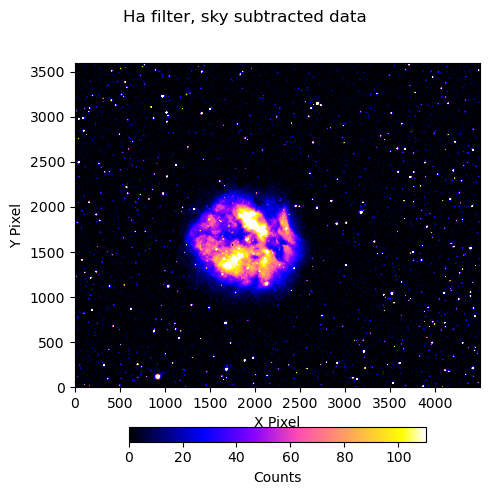

In [12]:
# Display sky subtracted IMAGE 

fig, ax = plt.subplots(figsize=(5, 5))  # ax is a single AxesSubplot when only one subplot is created
fig.suptitle("Ha filter, sky subtracted data")

# Single subplot, so no need to iterate
im = ax.imshow(Ha_filter_sky_subtracted[0], clim=[0,np.quantile(Ha_filter_sky_subtracted[0], [0.99])], cmap='gnuplot2', origin='lower')  
plt.colorbar(im, ax=ax, location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Attach colorbar to the single subplot
ax.set(xlabel="X Pixel", ylabel="Y Pixel")  # Set labels for the single axis

plt.tight_layout()
plt.show()

In [13]:
hdu = fits.PrimaryHDU(Ha_filter_sky_subtracted[0])
hdu.writeto('Ha_filter_science.fit', overwrite=True)